# Leitura do arquvio .csv, contendo os fatores de emissão.

In [114]:
import pandas as pd #Importa a biblioteca pandas as pd
import os           #Importa a biblioteca os

cwd = os.getcwd()   # cwd recebe o endereço do script

path = cwd+'\\tabelas\\FE'      #path recebe o endereço onde está o arquivo do fatores de emissão
print(path)                     #imprime o path para verificação

chapterNumer = 11
subChapter = 7
file = 'chpt_'+str(chapterNumer)+'_'+str(subChapter)+'.csv'  #file recebe path + o nome do arquivo
print(file)                       

fe = pd.read_csv(path+'\\'+file)            #fe recebe o arquivo csv
display(fe)

C:\Guilherme\ControleP\ENS410064\venv\scripts\tabelas\FE
chpt_11_7.csv


,Source,PM,SO2,NOX
0,BMP,0.0060,0.0,0.00
1,Secador,1.1500,0.0,0.00
2,Resfriador,0.0550,0.0,0.00
3,Granulacao,0.0950,0.0,0.00
4,Queima,0.2450,104.5,0.27
5,Refrigeracao,0.0335,0.0,0.00
6,Esmatacao,0.0950,0.0,0.00


# Função para leitura dos fatores de emissão e estimar a emissão

In [115]:
import matplotlib.pyplot as plt
import numpy as np

def verificacao_emissao (fe, df):
    
    emissao_pm_total = np.zeros(8737)     #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    emissao_so2_total = np.zeros(8737)    #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    emissao_nox_total = np.zeros(8737)    #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    df_emissao_por_fonte = pd.DataFrame(columns = ['Source', 'PM', 'SO2', 'NOX'])

#-------------------------------------Cálculo da emissão de PM durante o ano--------------------------------------------#
    
    for i, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de "df" pelo valor correspondente na linha i da coluna PM de "fe"
        emissao_pm = df['producao_diaria'] * row['PM'] # esse calculo nos dá um resultado na unidade kg/h  
        # Adicionar emissao_pm ao DataFrame emissao_pm
        df_emissao_por_fonte.loc[i, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[i, 'PM'] = emissao_pm.sum() # somando todos os valores e alocando na posição do DataFrame referente à fonte de PM 
        
        # Soma as emissões horárias das fontes para no final ter uma taxa de emissão total da particula:
        emissao_pm_total += emissao_pm
        

#-------------------------------------Cálculo da emissão de SO2 durante o ano--------------------------------------------#
    
    for j, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de "df" pelo valor correspondente na linha i da coluna PM de "fe"
        emissao_so2 = df['producao_diaria'] * row['SO2'] # esse calculo nos dá um resultado na unidade kg/h 
        # Adicionar emissao_so2 ao DataFrame emissao_so2_total
        df_emissao_por_fonte.loc[j, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[j, 'SO2'] = emissao_so2.sum() # somando todos os valores e alocando na posição do DataFrame referente à fonte de SO2 
        
        # Soma as emissões horárias das fontes para no final ter uma taxa de emissão total da particula:
        emissao_so2_total += emissao_so2

#-------------------------------------Cálculo da emissão de NOX durante o ano--------------------------------------------#
    
    for k, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_nox = df['producao_diaria'] * row['NOX']
        # Adicionar emissao_nox ao DataFrame emissao_nox_total
        df_emissao_por_fonte.loc[k, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[k, 'NOX'] = emissao_nox.sum() # somando todos os valores e alocando na posição do DataFrame referente à fonte de NOX

        # Soma as emissões horárias das fontes para no final ter uma taxa de emissão total da particula:
        emissao_nox_total += emissao_nox

#-------------------------------------Plotando o gráfico com os fatores de emissão -------------------------------------#

    fig,ax = plt.subplots(len(fe.columns)-1,1,sharex = True, figsize = (9,10))
    for ii in range(1,len(fe.columns)): #  Este loop for itera sobre os números de 1 até o número de COLUNAS em fe (len(fe.columns)). O uso de range(1, len(fe.columns)) exclui a primeira coluna
        plt.title('Fotores de emissões')
        ax[ii-1].bar(fe['Source'],fe.iloc[:,ii],color = ['#DAF7A6','red','cyan', 'green', 'blue', 'magenta','purple'])
        ax[ii-1].set_xlabel('Processo', fontsize=12) #fontsize=8 é um argumento usado para definir o tamanho da fonte
        ax[ii-1].set_ylabel(fe.columns[ii]+'\n(kg/ton)', fontsize=12)

    return emissao_pm_total, emissao_so2_total, emissao_nox_total, df_emissao_por_fonte #retorna a rotina principal 3 vetores contendo a emissão de cada particula no ano, mais um dataframe contendo as emissões de particulas por processo




# Criar sazonalidade e método Monte Carlo para estimar a produção em 1 ano (2023)

In [116]:
#criando o dataframe contendo todas as horas de 2023
i = pd.date_range(start='2023-01-01', end='2023-12-31', freq ='h') #cria um indice contendo todas as horas e dias do ano de 2023
df = pd.DataFrame(index = i) # cria um dataframe sendo que as linhas são as horas do ano


# Modelando a sazonalidade nos dias do ano usando uma função seno
df['sazonalidade'] = np.sin(2 * np.pi * df.index.dayofyear / 365) + 1.25  # Adicionando 1.25 para evitar valores de produção negativos e próximas a zero, já que nossa produção não possui eventos sem atividades 

#aplicando o método de monte carlo utilizando a biblioteca numpy

#considerando a produção de 535945.3782kg no ano de 2023, temos a taxa média por hora de 62.0307 kg/h. 

min_producao_hora = 62.0307*0.1        # como o processo não possui eventos sem atividade, então foi definido como mínimo 10% da capacidade média
max_producao_hora = 62.0307*1.1 # produção máxima definida, foi 50% mais que a capacidade média

#método Monte Carlo:

variabilidade = np.random.uniform(min_producao_hora, max_producao_hora, len(df))

df['variabilidade'] = variabilidade # adicionando a coluna 'variabilidade' do dataframe "df" os valores calculados de produção. 

#Multiplicando a sazonalidade com a variabilidade criada pelo método monte carlo, para assim termos as taxas. 

df['producao_diaria'] = df['sazonalidade']*df['variabilidade']


# Chamando a função *verificacao_emissao()* para calcular as emissões por processo e por particula 

# Gráfico: Fatores de emissões

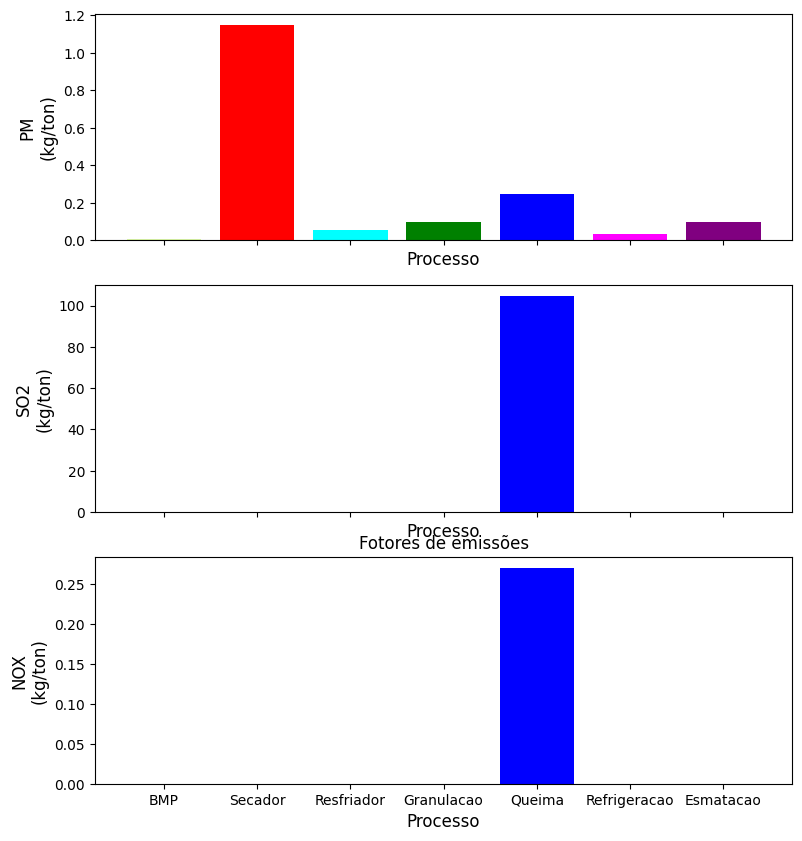

In [124]:
# resultado_pm, resultado_so2 e resultado_nox são vetores contendo o valor total, no ano, de emissão de cada particulas. 
# df_resultado é um dataframe contendo a emissão total de cada particula por processo

resultado_pm, resultado_so2, resultado_nox, df_resultado = verificacao_emissao(fe, df)

# Gráfico da sazonalidade durante o ano

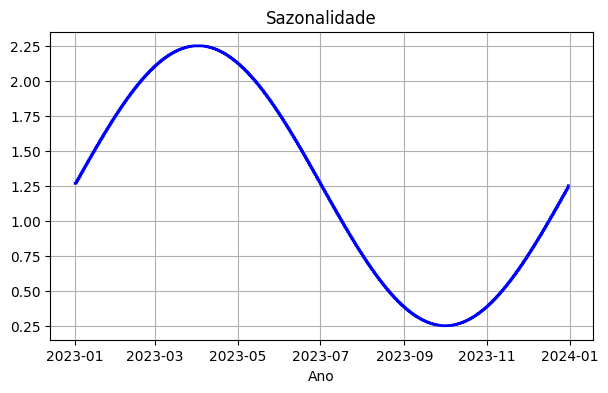

In [118]:
    plt.figure(figsize=(7, 4))
plt.plot(df.index, df['sazonalidade'], color='blue', linewidth=2)
plt.title('Sazonalidade')
plt.xlabel('Ano')
plt.ylabel('')
plt.grid(True)
plt.show()

# Gráfico da taxa de produção no ano, considerando a sazonalidade e o método monte carlo

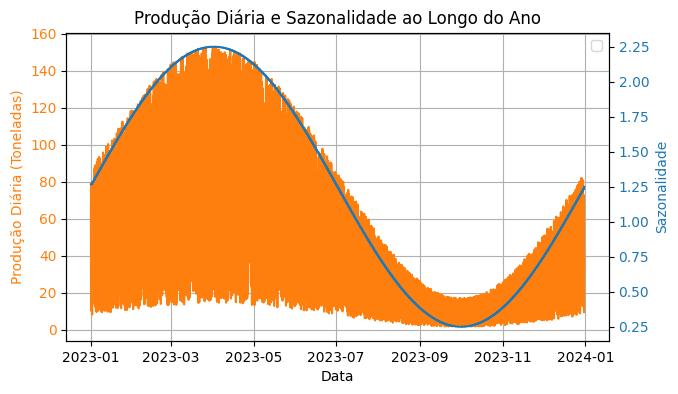

In [119]:
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plotar a produção diária
color = 'tab:orange'
ax1.set_xlabel('Data')
ax1.set_ylabel('Produção Diária (Toneladas)', color=color)
ax1.plot(df.index, df['producao_diaria'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Adicionar título e grid
ax1.set_title('Produção Diária e Sazonalidade ao Longo do Ano')
ax1.grid(True)

# Criar o segundo eixo y para a sazonalidade
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sazonalidade', color=color)
ax2.plot(df.index, df['sazonalidade'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adicionar legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['Produção Diária', 'Sazonalidade'])

plt.show()


# Gráfico representando a emissão de PM durante o ano

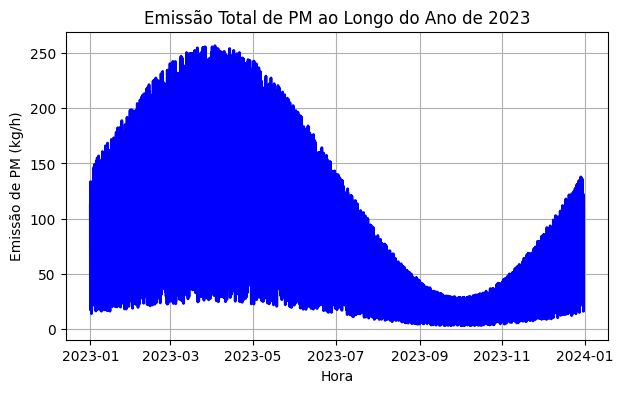

Resposta da pergunta 6c
soma de toda as emissões de PM =  188553.6364813455 g/s
média das emissões de PM =  21.581050301172656 g/s
mínimo valor de emissoes PM =  0.7541471535307095 g/s
máximo valor de emissoes PM =  71.33305837179188 g/s


In [120]:
plt.figure(figsize=(7, 4))
plt.plot(df.index, resultado_pm, color='blue', linewidth=2)
plt.title('Emissão Total de PM ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de PM (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_pm = resultado_pm.sum() * (1000/(60*60)) # Somatório de emissões PM em g/s
media_emissoes_pm = np.mean(resultado_pm) * (1000/(60*60)) # Média de emissões PM em g/s
minimo_emissoes_pm = np.min(resultado_pm) * (1000/(60*60)) # Mínimo de emissões PM em g/s
max_emissoes_pm = np.max(resultado_pm) * (1000/(60*60)) # Máximo de emissões PM em g/s

print('Resposta da pergunta 6c')

print('soma de toda as emissões de PM = ', soma_emissoes_pm, "g/s")
print('média das emissões de PM = ', media_emissoes_pm, "g/s")
print('mínimo valor de emissoes PM = ', minimo_emissoes_pm,"g/s")
print('máximo valor de emissoes PM = ', max_emissoes_pm, "g/s")



# Gráfico representando a emissão de SO2 durante o ano

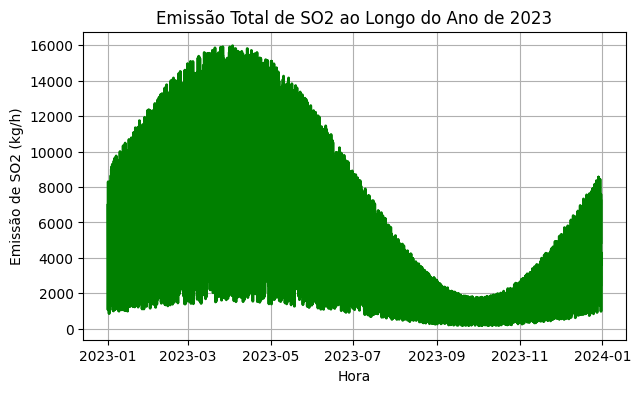

resposta da pergunta 6c
soma de toda as emissões de SO2 =  42235116.43005786
média das emissões de SO2 =  4834.052469961985
mínimo valor de emissoes SO2 =  168.92537014483656
máximo valor de emissoes SO2 =  15978.265292925336


In [121]:
plt.figure(figsize=(7, 4))
plt.plot(df.index, resultado_so2, color='green', linewidth=2)
plt.title('Emissão Total de SO2 ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de SO2 (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_so2 = resultado_so2.sum() # Somatório de emissões SO2 em g/s
media_emissoes_so2 = np.mean(resultado_so2) # Média de emissões SO2 em g/s
minimo_emissoes_so2 = np.min(resultado_so2) # Mínimo de emissões SO2 em g/s
max_emissoes_so2 = np.max(resultado_so2) # Máximo de emissões SO2 em g/s

print('resposta da pergunta 6c')
print('soma de toda as emissões de SO2 = ', soma_emissoes_so2)
print('média das emissões de SO2 = ', media_emissoes_so2)
print('mínimo valor de emissoes SO2 = ', minimo_emissoes_so2)
print('máximo valor de emissoes SO2 = ', max_emissoes_so2)

# Gráfico representando as emissões de NOX durante o ano

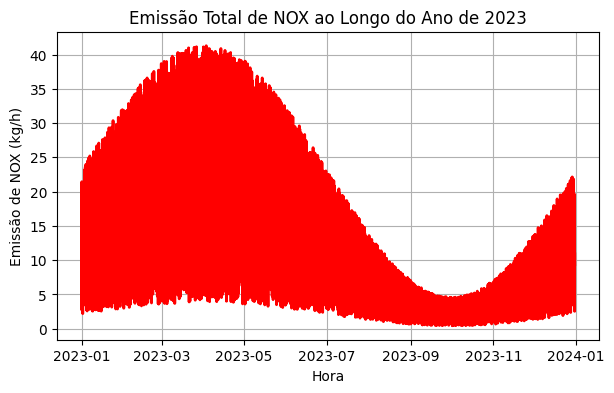

resposta da pergunta 6c
soma de toda as emissões de NOX =  109124.22426904902
média das emissões de NOX =  12.489896333873071
mínimo valor de emissoes NOX =  0.43645789415412317
máximo valor de emissoes NOX =  41.28355625923293


In [122]:
plt.figure(figsize=(7, 4))
plt.plot(df.index, resultado_nox, color='red', linewidth=2)
plt.title('Emissão Total de NOX ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de NOX (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_nox = resultado_nox.sum() # Soma de emissões NOX em g/s
media_emissoes_nox = np.mean(resultado_nox) # Média de emissões NOX em g/s
minimo_emissoes_nox = np.min(resultado_nox) # Mínimo de emissões NOX em g/s
max_emissoes_nox = np.max(resultado_nox) # Máximo de emissões NOX em g/s

print('resposta da pergunta 6c')
print('soma de toda as emissões de NOX = ', soma_emissoes_nox)
print('média das emissões de NOX = ', media_emissoes_nox)
print('mínimo valor de emissoes NOX = ', minimo_emissoes_nox)
print('máximo valor de emissoes NOX = ', max_emissoes_nox)

# Gráfico demonstrando as emissões por processo e por fator

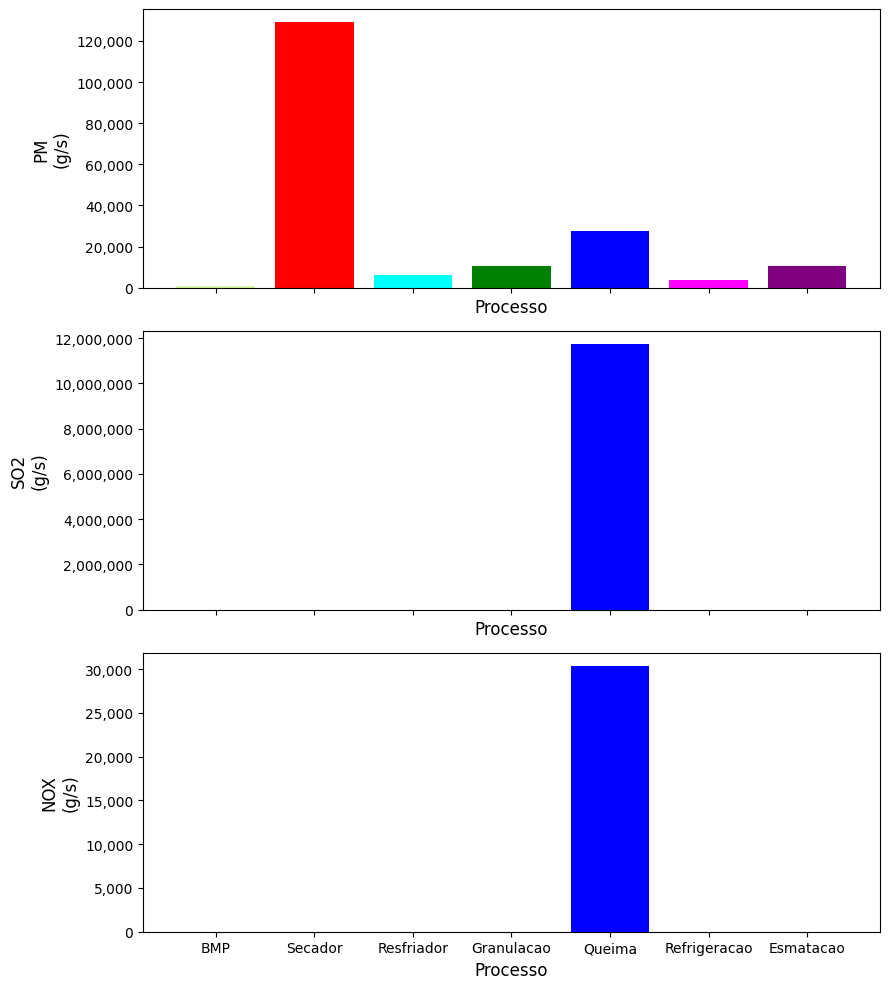

In [123]:
import matplotlib.ticker as ticker # biblioteca para exibir os valores no gráfico sem notação cietífica
# Criar a figura e os eixos
fig, ax = plt.subplots(len(df_resultado.columns)-1, 1, sharex=True, figsize=(9, 10))

# Iterar sobre as colunas do DataFrame df_resultado
for ii in range(1, len(df_resultado.columns)):
    # Plotar as barras para cada coluna
    ax[ii-1].bar(df_resultado['Source'], df_resultado.iloc[:, ii] * (1000/3600), color=['#DAF7A6', 'red', 'cyan', 'green', 'blue', 'magenta', 'purple'])
    # Definir os rótulos dos eixos
    ax[ii-1].set_xlabel('Processo', fontsize=12)  # Definir o rótulo do eixo x
    ax[ii-1].set_ylabel(fe.columns[ii]+'\n(g/s)', fontsize=12)  # Definir o rótulo do eixo y
    # Definir o tamanho da fonte para os rótulos dos eixos
    ax[ii-1].tick_params(axis='both', which='major', labelsize=10)  # Definir o tamanho da fonte dos rótulos dos eixos
    ax[ii-1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Formatar os valores do eixo Y sem notação científica


# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()
